In [1]:
# relative imports.
from user_input import (
    ConstantParamaters,
    VariableParamters,
    DataRetrieval,
    yay_or_nay
)
from fitting import (
    AlgorithmHelpers,
    find_initial_parameter_guesses,
    run_levenberg_marquardt,
    run_monte_carlo,
)
from save_plot import Plotting, SaveResults

# module imports.
from numpy import (
    append,
    array,
    log10,
    full,
)
from datetime import timedelta, datetime
from pathlib import Path
from time import time
from os import getcwd


input_constant = ConstantParamaters()
input_variable = VariableParamters()
data_retrieval = DataRetrieval()



In [2]:
#### Catch user input from terminal ####
# user_molfile = input_constant.molfile_input()
# user_datfile = input_constant.datafile_input()
# # user_molfile  = '/home/mooren/BT/moldata/co.dat'
# # user_datfile  = '/home/mooren/BT/reverseRadex/new_test.dat'

# # (matching) frequencies with molfile.
# freq_indices  = data_retrieval.get_molfile_frequency_index(user_datfile,
#                                                            user_molfile)
# freq          = data_retrieval.get_frequencies(freq_indices, user_molfile)
# user_mol_frequencies, freq_min, freq_max, number_of_lines_total = freq
# freq_range    = (freq_min, freq_max)

# # checking for units and uncertainties.
# units             = data_retrieval.get_user_units(user_datfile)
# uncertainties     = data_retrieval.uncertainties_included(user_datfile)
# (y_observed,
#  y_uncertainties) = data_retrieval.line_strengths(user_datfile,
#                                                   uncertainties)

# # constant parameters.
# Tbg             = input_constant.background_radiation_input()
# dv              = input_constant.line_width_input()
# geom, geom_name = input_constant.geometry_input()

# # variable parameters.
# temp_kin = input_variable.kinetic_temperature_input()
# coldens  = input_variable.column_density_input()
# voldens  = input_variable.collision_densities_input()
#### Catch user input from terminal ####



In [3]:
#### If you would like to set the input manually, uncomment the cell ####


user_molfile  = '/home/mooren/BT/moldata/co.dat'
user_datfile  = '/home/mooren/BT/reverseRadex/new_test.dat'
freq_indices  = data_retrieval.get_molfile_frequency_index(user_datfile,
                                                           user_molfile)
freq          = data_retrieval.get_frequencies(freq_indices, user_molfile)
user_mol_frequencies, freq_min, freq_max, number_of_lines_total = freq
freq_range    = (freq_min, freq_max)


units             = data_retrieval.get_user_units(user_datfile)
uncertainties     = data_retrieval.uncertainties_included(user_datfile)
(y_observed,
 y_uncertainties) = data_retrieval.line_strengths(user_datfile,
                                                  uncertainties)

# variable parameters.
# [name parameter, init guess, (bound_low, bound_upp), fit parameter?]
# 0.1 < tkin < 1e4 [K]
temp_kin = ['tkin', 131, (10.0, 750.0), True]
# 1e5 < cdmol 1e25 [cm^-2]
coldens  = ['cdmol', 3e16, (1e10, 5e21), True]
# coll partner:(init guess, fit parameter?)
# 1e-3 < coll partner < 1e13 [cm^-3]
voldens  = {'h2':(3e4, True), 'h':(0.0, False), 'e-':(0.0, False),
            'p-h2':(0, False), 'o-h2':(0.0, False), 'h+':(0.0, False),
            'he':(0.0, False), 'min_max':(1e3, 1e7)}

# constant parameters.
Tbg  = 2.73  # K
dv   = 1.0   # km s^-1
geom = 1     #(1=sphere, 2=LVG, 3=slab)
# just for displaying purposes,
geom_name = 'uniform sphere'


#### If you would like to set the input manually, uncomment the cell ####

##### No user input required beyond this point #####
##### Unless you want to tweak the algorithms  #####



In [4]:
# printing the chosen settings for user to check.
print(f"\n\nSelected molfile path              : '{user_molfile}'")
print(f"Selected datafile path             : '{user_datfile}'")
print(f"Selected line strength units       : {units}")
print(f"uncertainties included             : {uncertainties}")
print("\n\n[name of parameter, parameter value, (lower bound, upper" +
      " bound), fit parameter?]")
print('If a parameter is fit, "parameter value" is a dummy number and ' +
      'can be ignored.\nIf not fit, the boundaries are dummy numbers.\n' +
      "0.0 just indicates SpectralRadex to not use this collision " +
      "partner.\n")
print(f"Selected minimum and maximum \n" +
      f"kinetic gas cloud temperature      : {temp_kin} K")
print(f"Selected background radiation field: {Tbg} K")
print(f"Selected minimum and maximum \n" +
      f"column densities                   : {coldens} cm^-2")


constant_parameters = {
    'tbg':Tbg, 'fmin':freq_min, 'fmax':freq_max, 'linewidth':dv,
    'geometry':geom, 'molfile':user_molfile
}

# handeling the kinetic temperatrue and column density.
lim_low = array([])
lim_upp = array([])
tkin_cd = [temp_kin, coldens]
lims_to_save = {}
for parameter in tkin_cd:
    prm_name, prm_value, prm_bounds, prm_fit = parameter
    if prm_fit == True:
        prm_low, prm_upp = prm_bounds
        lim_low = append(lim_low, log10(prm_low))
        lim_upp = append(lim_upp, log10(prm_upp))
        lims_to_save[prm_name] = (lim_low[-1], lim_upp[-1])
    else:
        constant_parameters[prm_name] = prm_value

# handeling the collision partners (volume densities).
str_voldens = "Selected volume densities [cm^-3],  "
print(str_voldens)
vol_dens_summary = []
min_max = 'min_max'
for collision_partner in voldens:
    if collision_partner != min_max:
        blank = ''.ljust(len(str_voldens) -
                         len(collision_partner) - 1) + ":"
        param_value, param_fit = voldens[collision_partner]
        voldens_min, voldens_max = voldens[min_max]
        vol_dens_summary += [[collision_partner, param_value,
                              (voldens_min, voldens_max), param_fit]]
        print(f"{collision_partner}" + blank +
              f" {vol_dens_summary[-1]}")
        if param_fit == False:
            constant_parameters[collision_partner] = param_value
        else:
            lim_low = append(lim_low, log10(voldens_min))
            lim_upp = append(lim_upp, log10(voldens_max))
            lims_to_save[collision_partner] = (lim_low[-1], lim_upp[-1])

# printing remaining input.
print(f"Selected line width                : {dv} km/s")
print(f"Selected minimum and maximum \n" +
      f"frequency                          : {freq_range} GHz")
print(f"Selected geometry                  : {geom_name}")


# check if any of the parameters is set to be fit.
if lim_low.shape[0] == 0:
    raise AssertionError("No parameter is set to be fit.")

# check if more data is available than parameters to fit.
# getting the names of the parameters to be fit, the order is important.
all_parameter_names = ['molfile', 'tkin', 'cdmol', 'tbg', 'h2', 'p-h2',
                       'o-h2', 'e-', 'h', 'he', 'h+', 'fmin', 'fmax',
                       'linewidth', 'geometry']
fit_parameters_names = []
for parameter_name in all_parameter_names:
    if parameter_name not in constant_parameters.keys():
        fit_parameters_names += [parameter_name]

len_data     = len(y_observed)
len_fit_prms = len(fit_parameters_names)
if (len_data > len_fit_prms) != True:
    raise AssertionError(f"{len_data} observed data points is not "
                         f"enough data to fit {len_fit_prms} parameters" +
                         ". Need: 'data > parameters + 1'.")

# prompt user to either continue to the fitting process or terminate.
user_prms_check = yay_or_nay("\nContinue to the fitting process? (y/n) ")
if user_prms_check == '' or user_prms_check == True:
    pass
else:
    raise KeyboardInterrupt("User terminated the program.")






Selected molfile path              : '/home/mooren/BT/moldata/co.dat'
Selected datafile path             : '/home/mooren/BT/reverseRadex/new_test.dat'
Selected line strength units       : FLUX (erg/cm2/s)
uncertainties included             : yes


[name of parameter, parameter value, (lower bound, upper bound), fit parameter?]
If a parameter is fit, "parameter value" is a dummy number and can be ignored.
If not fit, the boundaries are dummy numbers.
0.0 just indicates SpectralRadex to not use this collision partner.

Selected minimum and maximum 
kinetic gas cloud temperature      : ['tkin', 131, (10.0, 750.0), True] K
Selected background radiation field: 2.73 K
Selected minimum and maximum 
column densities                   : ['cdmol', 3e+16, (10000000000.0, 5e+21), True] cm^-2
Selected volume densities [cm^-3],  
h2                                 : ['h2', 30000.0, (1000.0, 10000000.0), True]
h                                  : ['h', 0.0, (1000.0, 10000000.0), False]
e-          

In [5]:
# since the frequency range is used to limit the radex output, the
# indices have to be shifted to accommodate for that (for instance, the
# range might start at 300 GHz while lines exist < 300 GHz. Therefore, the
# index needs to be shifted).
matching_index = list(map(lambda add: add - freq_indices[0], freq_indices))

# create an index array to be used for cutting the SpectralRadex output
# to match the spectral lines present in the user supplied data file.
matching_lines = full(number_of_lines_total, False)
matching_lines[matching_index] = True



In [6]:
### start of main program ###
start_time = time()

#### global parameter search ####
print("\nEstimating initial parameters.")
# use the brute method global search to find initial estimates for
# paremeters to be fit.
cst_prms = [user_molfile, Tbg, dv, freq_min, freq_max, geom, units,
            matching_index, user_datfile, uncertainties]
global_parameter_estimates = find_initial_parameter_guesses(
    temp_kin, coldens, voldens, vol_dens_summary, cst_prms
)

grid_time = time()
grid_duration  = grid_time - start_time
grid_duration_HHMMSS = str(timedelta(seconds=grid_duration)).rpartition('.')[0]
print(f"Time elapsed: {grid_duration_HHMMSS}")
print("Global parameter estimates resulting from brute " +
      "(grid search) method:")
for name, value in zip(fit_parameters_names, global_parameter_estimates):
    print(f"log10({name}): {value:.5f}")




Estimating initial parameters.
Time elapsed: 0:00:20
Global parameter estimates resulting from brute (grid search) method:
log10(tkin): 1.94396
log10(cdmol): 14.25417
log10(h2): 6.50000


In [7]:
#### setting up Levenberg-Marquardt and MCMC parameters ####
alg_help = AlgorithmHelpers(
    y_observed,
    y_uncertainties,
    units,
    lim_low,
    lim_upp,
    constant_parameters,
    matching_lines,
    fit_parameters_names
)



In [8]:
#### Levenberg-Marquardt least squares to refine parameter estimates ####
print("\nRefining parameter estimates.")
initial_parameters = run_levenberg_marquardt(global_parameter_estimates,
                                             alg_help.RADEX_model,
                                             y_observed,
                                             y_uncertainties)

LM_time = time()
LM_duration  = LM_time - start_time
LM_duration_HHMMSS = str(timedelta(seconds=LM_duration)).rpartition('.')[0]
print(f"Time elapsed: {LM_duration_HHMMSS}")
print("Refined parameter estimates resulting from Levenberg-Marquardt:")
for name, value in zip(fit_parameters_names, initial_parameters):
    print(f"log10({name}): {value:.5f}")




Refining parameter estimates.
Time elapsed: 0:00:25
Refined parameter estimates resulting from Levenberg-Marquardt:
log10(tkin): 2.07918
log10(cdmol): 15.00000
log10(h2): 5.00000


In [9]:
#### MCMC for uncertainty estimates ####
N = 500  # number of steps the MCMC algorithm takes.
print("\nRunning MCMC for uncertainty estimates,")
MCMC_output, ndim = run_monte_carlo(initial_parameters,
                                    alg_help.log_probability,
                                    number_of_steps=N)




Running MCMC for uncertainty estimates,
100%|██████████| 500/500 [02:51<00:00,  2.92it/s]


In [10]:
### end of main program ###
end_time = time()
duration = end_time - start_time
duration_HH_MM_SS = str(timedelta(seconds=duration)).rpartition('.')[0]
print(f"\nRun time of main program: {duration_HH_MM_SS}.")




Run time of main program: 0:03:17.



Parameter estimates and accompanying upper and lower uncertainties,
Percental:   50%   |   16%   |   84%   
tkin    : 2.22752 | -0.31689 | +0.34678
cdmol    : 14.97258 | -0.04271 | +0.02993
h2    : 4.67850 | -0.55708 | +0.85084


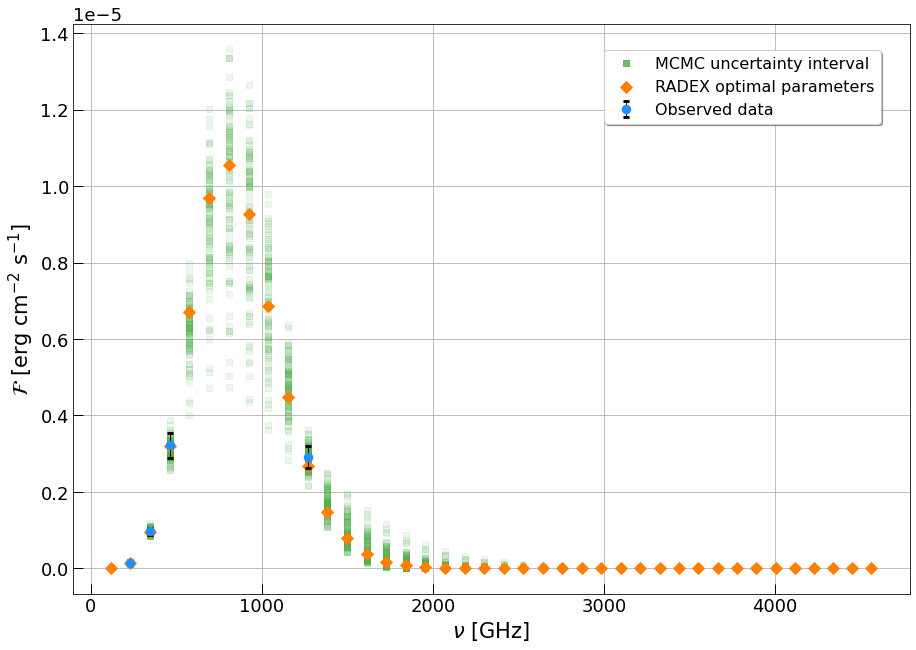


Results saved to /home/mooren/BT/reverseRadex/output/2021.07.02-15.55.05.



In [11]:
##### plotting and saving of results #####
date_time = datetime.now().strftime("%Y.%m.%d-%H.%M.%S")
# FIXME: add which molecule is used?
# create output directory.
cwd         = getcwd()
output_path = cwd + f'/output/{date_time}'
Path(output_path).mkdir()


### saving ###
saving = SaveResults(
    MCMC_output,
    output_path,
    constant_parameters,
    fit_parameters_names
)

# saving MCMC ensamble.
saving.save_MCMC_sampler()

# saving RADEX.csv output and obtaining parameter medians.
prms_50s = saving.RADEX_for_optimal_parameters(
    user_datfile, user_mol_frequencies, y_observed, y_uncertainties,
    freq_indices, units, lims_to_save
)
### saving ###


### plotting ###
plot = Plotting(
    MCMC_output,
    output_path,
    prms_50s,
    fit_parameters_names
)

# Plotting and saving the corner plot.
plot.plot_corner()

# Plotting the molecular spectrum.
plot.plot_spectrum(
    units, y_observed, y_uncertainties, constant_parameters,
    user_mol_frequencies
)
### plotting ###


print(f"\nResults saved to {output_path}.\n")

